# Milestone 2: Feature Engineering, Feature Selection, and Modeling

**Project Title:** Predicting S&P 500 Monthly Returns

**Objective:** I have built both classification and regression models to predict the direction and magnitude of S&P 500 returns based on gold prices and real estate indicators.

**Datasets:** Cleaned financial data for S&P 500, Gold, and Real Estate from Milestone 1.

---

In [9]:
# Install all required libraries for EDA, modeling, and visualization
!pip install pandas numpy scipy scikit-learn seaborn matplotlib lightgbm jinja2 imbalanced-learn xgboost

In [10]:
# **IMPORTS AND SETUPS**

# Import commonly used libraries for data analysis and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Regression and classification models
from sklearn.linear_model import LinearRegression, RidgeCV, ElasticNetCV, LassoCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc

# Scaling
from sklearn.preprocessing import RobustScaler

# Metrics for evaluating models
from sklearn.neighbors import KNeighborsClassifier

# External libraries
import xgboost as xgb
from lightgbm import  LGBMRegressor
import warnings
warnings.filterwarnings("ignore")


In [2]:
# **LOAD AND PROCESS CLEANED DATA FROM MILESTONE 1**

# Load data
gold = pd.read_csv("../Data/GOLD_cleaned.csv")
real_estate = pd.read_csv("../Data/RealEstate_cleaned.csv", usecols=["List Year", "Assessed Value", "Sale Amount", "Sales Ratio"])
sp500 = pd.read_csv("../Data/sp500_cleaned.csv")

# Parse dates
gold['date'] = pd.to_datetime(gold['date'])
sp500['date'] = pd.to_datetime(sp500['date'])
real_estate['List Year'] = pd.to_datetime(real_estate['List Year'], format='%Y')

# Preview data
print("GOLD data:")
print(gold.head(), "\n")

print("REAL ESTATE data:")
print(real_estate.head(), "\n")

print("S&P 500 data:")
print(sp500.head())



GOLD data:
                 date     open    high      low    close     rsi14     sma14  \
0 2010-01-03 18:00:00  1098.45  1100.0  1098.05  1099.95  0.842004  0.044514   
1 2010-01-03 18:05:00  1100.00  1100.3  1099.45  1099.75  0.812047  0.044833   
2 2010-01-03 18:10:00  1099.70  1100.1  1099.30  1099.45  0.767804  0.045123   
3 2010-01-03 18:15:00  1099.50  1099.6  1098.50  1099.45  0.767804  0.045376   
4 2010-01-03 18:20:00  1099.40  1099.6  1098.90  1098.90  0.687633  0.045563   

   year  month  day  day_of_week  hour  
0  2010      1    3            6    18  
1  2010      1    3            6    18  
2  2010      1    3            6    18  
3  2010      1    3            6    18  
4  2010      1    3            6    18   

REAL ESTATE data:
   List Year  Assessed Value  Sale Amount  Sales Ratio
0 2020-01-01        0.556807     0.711318     0.390944
1 2020-01-01        0.286131     0.295662     0.522301
2 2021-01-01        0.505807     0.930447     0.218495
3 2021-01-01        0.

In [3]:
#**AGGREGATE MONTHLY AND YEARLY DATA**

# S&P 500 monthly
sp500_monthly = sp500.groupby(pd.Grouper(key='date', freq='M')).agg({
    'index': ['mean', 'std'],
    'volume': ['mean'],
    'close': ['mean']
})
sp500_monthly.columns = ['_'.join(col) for col in sp500_monthly.columns]
sp500_monthly = sp500_monthly.rename(columns={
    'index_mean': 'sp500_index_mean',
    'index_std': 'sp500_index_std',
    'volume_mean': 'sp500_volume_mean',
    'close_mean': 'sp500_close_mean'
}).reset_index()

# Gold monthly
gold_monthly = gold.groupby(pd.Grouper(key='date', freq='M')).agg({
    'close': 'mean',
    'rsi14': 'mean'
}).rename(columns={
    'close': 'gold_close_mean',
    'rsi14': 'gold_rsi14_mean'
}).reset_index()

# Real estate yearly
real_estate['year'] = real_estate['List Year'].dt.year
real_estate_yearly = real_estate.groupby('year').agg({
    'Sale Amount': 'mean',
    'Sales Ratio': 'mean'
}).rename(columns={
    'Sale Amount': 'real_estate_sale_mean',
    'Sales Ratio': 'real_estate_ratio_mean'
}).reset_index()
real_estate_yearly['year_date'] = pd.to_datetime(real_estate_yearly['year'], format='%Y')

# Preview aggregated monthly S&P 500 data
print("S&P 500 Monthly Aggregated Data:")
print(sp500_monthly.head(), "\n")

# Preview aggregated monthly Gold data
print("Gold Monthly Aggregated Data:")
print(gold_monthly.head(), "\n")

# Preview aggregated yearly Real Estate data
print("Real Estate Yearly Aggregated Data:")
print(real_estate_yearly.head())

print(f"S&P 500 monthly rows: {len(sp500_monthly)}")
print(f"Gold monthly rows: {len(gold_monthly)}")
print(f"Real estate yearly rows: {len(real_estate_yearly)}")

print(sp500_monthly.describe())



S&P 500 Monthly Aggregated Data:
        date  sp500_index_mean  sp500_index_std  sp500_volume_mean  \
0 2014-12-31       2080.168571         9.596985       4.131326e+06   
1 2015-01-31       2028.178500        21.440746       7.638213e+06   
2 2015-02-28       2082.195789        28.359935       7.061232e+06   
3 2015-03-31       2079.987060        21.633299       7.622198e+06   
4 2015-04-30       2094.862857        15.602638       7.323220e+06   

   sp500_close_mean  
0         62.800444  
1         61.779662  
2         63.299240  
3         63.815792  
4         64.226682   

Gold Monthly Aggregated Data:
        date  gold_close_mean  gold_rsi14_mean
0 2010-01-31      1118.549644         0.499893
1 2010-02-28      1097.189431         0.511682
2 2010-03-31      1114.798271         0.509173
3 2010-04-30      1148.096479         0.509778
4 2010-05-31      1204.205082         0.511507 

Real Estate Yearly Aggregated Data:
   year  real_estate_sale_mean  real_estate_ratio_mean  year_d

In [14]:
#**MERGE ALL ECONOMICS DATA**

base_dates = pd.date_range(start='2010-01-01', end='2023-12-01', freq='M')
df = pd.DataFrame({'date': base_dates})
df['year_date'] = df['date'].dt.to_period('Y').dt.to_timestamp()

df = df.merge(sp500_monthly, on='date')
df = df.merge(gold_monthly, on='date')
df = df.merge(real_estate_yearly.drop(columns='year'), on='year_date')

print("Merged DataFrame Preview:")
print(df.head(), "\n")



# Optional: Check for missing values
print("\nMissing values after merge:")
print(df.isna().sum())



Merged DataFrame Preview:
        date  year_date  sp500_index_mean  sp500_index_std  sp500_volume_mean  \
0 2014-12-31 2014-01-01       2080.168571         9.596985       4.131326e+06   
1 2015-01-31 2015-01-01       2028.178500        21.440746       7.638213e+06   
2 2015-02-28 2015-01-01       2082.195789        28.359935       7.061232e+06   
3 2015-03-31 2015-01-01       2079.987060        21.633299       7.622198e+06   
4 2015-04-30 2015-01-01       2094.862857        15.602638       7.323220e+06   

   sp500_close_mean  gold_close_mean  gold_rsi14_mean  real_estate_sale_mean  \
0         62.800444      1200.294235         0.500867               0.394878   
1         61.779662      1250.968767         0.509374               0.389697   
2         63.299240      1230.112852         0.498501               0.389697   
3         63.815792      1180.640764         0.496988               0.389697   
4         64.226682      1199.947702         0.499626               0.389697   

   rea

In [5]:
#**FEATURE ENGINEERING AND TARGET CONSTRUCTION**

# Calculate returns
df['sp500_return'] = df['sp500_close_mean'].pct_change()
df['gold_return'] = df['gold_close_mean'].pct_change()
df['real_estate_return'] = df['real_estate_sale_mean'].pct_change()

# Lag and rolling features
df['gold_return_lag1'] = df['gold_return'].shift(1)
df['re_return_lag1'] = df['real_estate_return'].shift(1)
df['sp500_vol_3m'] = df['sp500_return'].rolling(3).std()
df['sp500_roll_mean_3'] = df['sp500_close_mean'].rolling(3).mean()
df['gold_roll_mean_3'] = df['gold_close_mean'].rolling(3).mean()
df['price_to_rollavg'] = df['sp500_close_mean'] / df['sp500_roll_mean_3']
df['gold_to_sp500'] = df['gold_close_mean'] / df['sp500_close_mean']
df['re_to_gold'] = df['real_estate_sale_mean'] / df['gold_close_mean']
df['trend_3m'] = df['sp500_close_mean'].pct_change(3)
df['trend_6m'] = df['sp500_close_mean'].pct_change(6)

# Smoothed regression target
df['sp500_return_smooth'] = df['sp500_return'].rolling(3).mean()

print("Feature Engineering Complete!\n")
print("Sample of new features:")
print(df[['sp500_return', 'gold_return', 'real_estate_return',
          'gold_return_lag1', 're_return_lag1', 'sp500_vol_3m',
          'price_to_rollavg', 'gold_to_sp500', 're_to_gold',
          'trend_3m', 'trend_6m', 'sp500_return_smooth']].head(10))

print("\nNumber of rows before dropping NaNs:", len(df))
print("Number of rows with NaNs (to be dropped):", df.isna().sum().max())



Feature Engineering Complete!

Sample of new features:
   sp500_return  gold_return  real_estate_return  gold_return_lag1  \
0           NaN          NaN                 NaN               NaN   
1     -0.016254     0.042218           -0.013122               NaN   
2      0.024597    -0.016672            0.000000          0.042218   
3      0.008160    -0.040218            0.000000         -0.016672   
4      0.006439     0.016353            0.000000         -0.040218   
5      0.010338    -0.001218            0.000000          0.016353   
6     -0.001277    -0.013262            0.000000         -0.001218   
7      0.001870    -0.043684            0.000000         -0.013262   
8     -0.012071    -0.011048            0.000000         -0.043684   
9     -0.045645     0.005928            0.000000         -0.011048   

   re_return_lag1  sp500_vol_3m  price_to_rollavg  gold_to_sp500  re_to_gold  \
0             NaN           NaN               NaN      19.112830    0.000329   
1             

In [6]:
#**FEATURE SELECTION**

# Drop NA
selected_features = [
    'gold_return_lag1', 're_return_lag1',
    'sp500_vol_3m', 'sp500_roll_mean_3',
    'gold_roll_mean_3', 'price_to_rollavg',
    'gold_to_sp500', 're_to_gold',
    'trend_3m', 'trend_6m',
    'sp500_index_std', 'sp500_volume_mean',
    'gold_rsi14_mean', 'real_estate_ratio_mean'
]
df.dropna(subset=['sp500_return', 'sp500_return_smooth'] + selected_features, inplace=True)

# Classification target (balanced)
df['sp500_direction'] = pd.qcut(df['sp500_return'], q=2, labels=[0, 1])

print(" Dropped rows with missing values in features/targets.")




 Dropped rows with missing values in features/targets.


In [8]:
#**SPLITTING, SCALING AND PREPARING DATA**

X = df[selected_features]
y_reg = df['sp500_return_smooth']
y_clf = df['sp500_direction'].astype(int)

train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train_reg, y_test_reg = y_reg[:train_size], y_reg[train_size:]
y_train_clf, y_test_clf = y_clf[:train_size], y_clf[train_size:]

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [11]:
#**DEFINE MODELS**
'''Regression Model Justification

I used a variety of regression models to predict smoothed S&P 500 returns:

- Linear Regression provides a basic benchmark for linear trends.
- Ridge Regression (RidgeCV) applies L2 regularization to address feature multicollinearity and reduce overfitting.
- Random Forest Regressor is a nonlinear ensemble model that captures complex interactions.
- Gradient Boosting Regressor builds trees sequentially to minimize error and improve predictions over time.
- LightGBM Regressor is a high-performance boosting model optimized for speed and accuracy.
- XGBoost Regressor is a state-of-the-art boosting algorithm with regularization and advanced tree pruning for better generalization.

Using both linear and nonlinear models ensures we compare simple and complex fits to identify the best approach for our return prediction.
'''
regressors = {
    'Linear': LinearRegression(),
    
    'Ridge': RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0]),
    
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=4, random_state=42),
    
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42),
    
    'LightGBM': LGBMRegressor(n_estimators=100, max_depth=3, random_state=42),
    
    'XGBoost': xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
}
print("Regression models initialized:")
print(list(regressors.keys()))

'''
Model Selection Justification
I used a diverse mix of models for both regression and classification tasks:
- Linear and Logistic Regression provide interpretable baselines.
- RidgeCV applies regularization to prevent overfitting on correlated features.
- Tree-based models like Random Forest, Gradient Boosting, LightGBM, and XGBoost are robust to feature scaling, capture nonlinear patterns, and often yield high accuracy.
- KNN gives a contrast by using distance-based classification.

This combination ensures we compare simple, regularized, and ensemble methods for best performance.

'''
classifiers = {
    'Logistic': LogisticRegression(max_iter=1000),
    
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=4, min_samples_leaf=5, random_state=42),
    
    'XGBoost': xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42),
    
    'KNN': KNeighborsClassifier(n_neighbors=5)
}
print("\nClassification models initialized:")
print(list(classifiers.keys()))


Regression models initialized:
['Linear', 'Ridge', 'RandomForest', 'GradientBoosting', 'LightGBM', 'XGBoost']

Classification models initialized:
['Logistic', 'RandomForest', 'XGBoost', 'KNN']


In [12]:
#**EVALUATION FUNCTIONS**
def plot_roc(model, X_test, y_test, label):
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    print(f"ROC curve plotted for {label} (AUC = {auc_score:.2f})")



--- REGRESSION ---


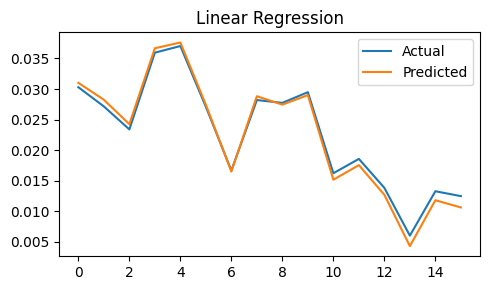

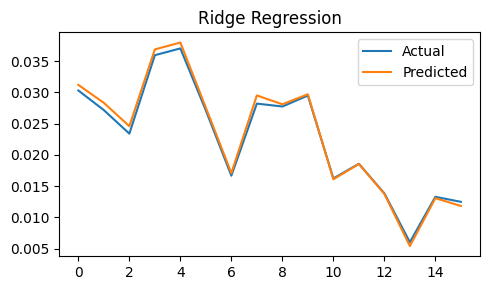

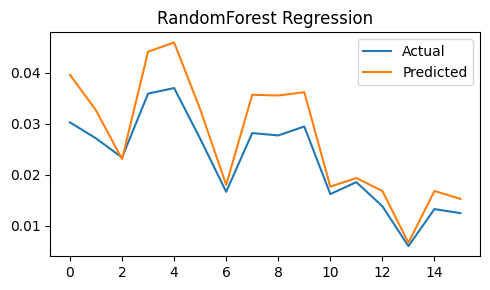

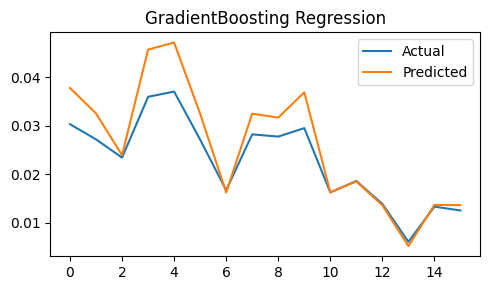

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 63, number of used features: 13
[LightGBM] [Info] Start training from score 0.008527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

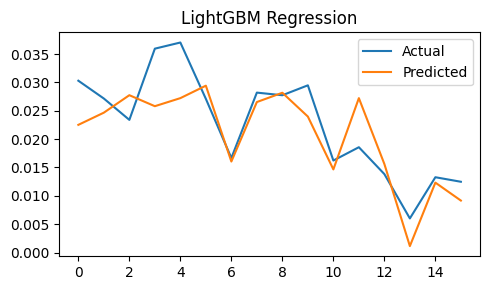

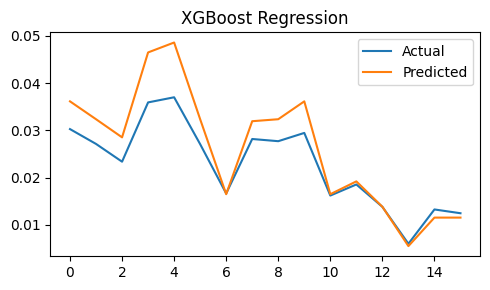

                      R2    RMSE
Model                           
Linear            0.9869  0.0010
Ridge             0.9931  0.0007
RandomForest      0.5954  0.0056
GradientBoosting  0.6723  0.0050
LightGBM          0.6410  0.0052
XGBoost           0.6345  0.0053


,R2,RMSE
Model,,
Linear,0.986894,0.001002
Ridge,0.993084,0.000728
RandomForest,0.595402,0.005565
GradientBoosting,0.672308,0.005008
LightGBM,0.640968,0.005242
XGBoost,0.634508,0.005289



--- CLASSIFICATION ---
ROC curve plotted for Logistic (AUC = 0.84)
Plotted ROC for: Logistic


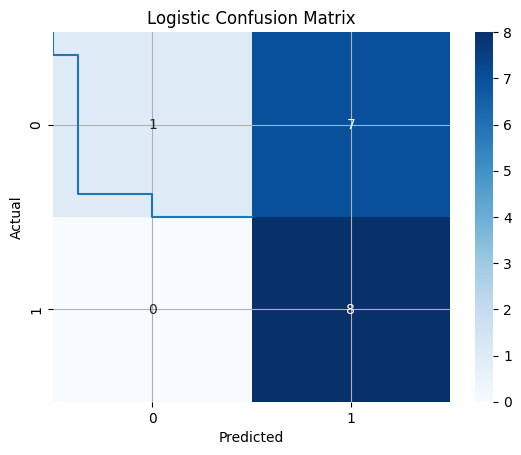

ROC curve plotted for RandomForest (AUC = 0.78)
Plotted ROC for: RandomForest


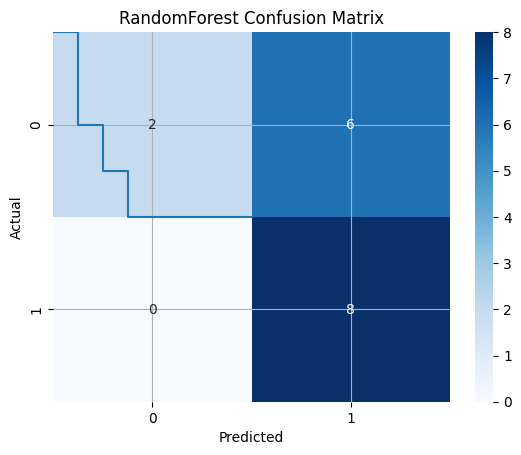

ROC curve plotted for XGBoost (AUC = 0.91)
Plotted ROC for: XGBoost


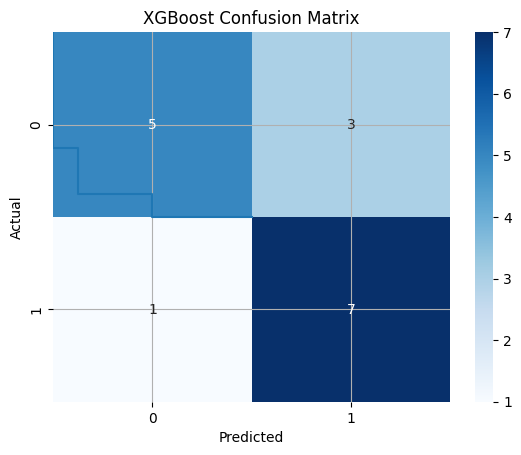

ROC curve plotted for KNN (AUC = 0.76)
Plotted ROC for: KNN


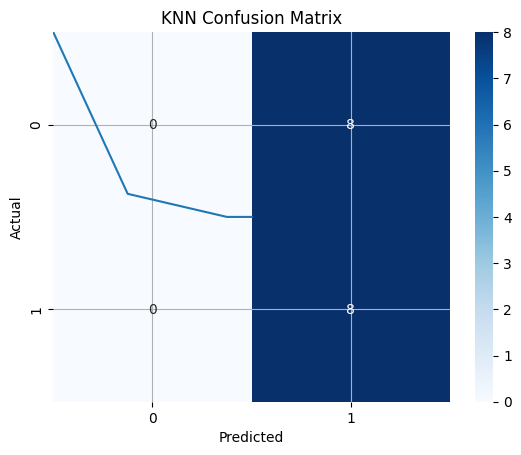

No ROC curves were plotted.
              Accuracy      F1     AUC
Model                                 
Logistic        0.5625  0.6957  0.8438
RandomForest    0.6250  0.7273  0.7812
XGBoost         0.7500  0.7778  0.9062
KNN             0.5000  0.6667  0.7578


,Accuracy,F1,AUC
Model,,,
Logistic,0.562500,0.695652,0.843750
RandomForest,0.625000,0.727273,0.781250
XGBoost,0.750000,0.777778,0.906250
KNN,0.500000,0.666667,0.757812


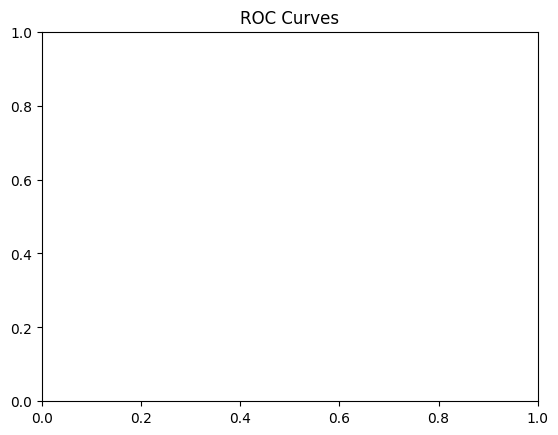

In [13]:
#**RUNNING OUR REGRESSION AND CLASSIFICATION MODELS**

def run_models(X_train, X_test, y_train_reg, y_test_reg, y_train_clf, y_test_clf):
    print("\n--- REGRESSION ---")
    reg_results = []
    for name, model in regressors.items():
        model.fit(X_train, y_train_reg)
        pred = model.predict(X_test)
        r2 = r2_score(y_test_reg, pred)
        rmse = np.sqrt(mean_squared_error(y_test_reg, pred))
        reg_results.append({"Model": name, "R2": r2, "RMSE": rmse})
        plt.figure(figsize=(5, 3))
        plt.plot(y_test_reg.values, label='Actual')
        plt.plot(pred, label='Predicted')
        plt.title(f"{name} Regression")
        plt.legend()
        plt.tight_layout()
        plt.show()
    reg_df = pd.DataFrame(reg_results).set_index("Model")
    print(reg_df.round(4))
    display(reg_df.style.highlight_max(axis=0))

    print("\n--- CLASSIFICATION ---")
    clf_results = []
    for name, model in classifiers.items():
        model.fit(X_train, y_train_clf)
        pred = model.predict(X_test)
        proba = model.predict_proba(X_test)[:, 1]
        acc = accuracy_score(y_test_clf, pred)
        f1 = f1_score(y_test_clf, pred)
        auc_score = roc_auc_score(y_test_clf, proba)
        clf_results.append({"Model": name, "Accuracy": acc, "F1": f1, "AUC": auc_score})
        plot_roc(model, X_test, y_test_clf, name)
        print(f"Plotted ROC for: {name}")
        cm = confusion_matrix(y_test_clf, pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"{name} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    plt.title("ROC Curves")
    if plt.gca().has_data():
        plt.plot([0, 1], [0, 1], 'k--')
        plt.grid()
        plt.legend()
        plt.show()
    else:
        print("No ROC curves were plotted.")

    clf_df = pd.DataFrame(clf_results).set_index("Model")
    print(clf_df.round(4))
    display(clf_df.style.highlight_max(axis=0))
run_models(X_train_scaled, X_test_scaled, y_train_reg, y_test_reg, y_train_clf, y_test_clf)
